# Bayesian Vital‐Rate Model for Retrogressive Thaw Slumps

This notebook fits a **hierarchical, individual‑based state‑space model** that couples climate, slump‑face area, and population turnover in absolute physical units (°C · day, mm, W m⁻²).

| Layer          | Response                                                              | Predictors (original units)                                      | Link / Likelihood             |
| -------------- | --------------------------------------------------------------------- | ---------------------------------------------------------------- | ----------------------------- |
| **Survival**   | Indicator a slump active in year *t* is still active in *t + 1* (0/1) | log‑area\*, °C·day, mm extreme precipitation, W m⁻² radiation    | *logit* → Bernoulli           |
| **Growth**     | Log‑area in *t + 1* (conditional on survival)                         | log‑area in *t* (autoregression ρ), °C·day, mm precip, W m⁻² rad | identity → Student‑T          |
| **Initiation** | Number of **new** slumps in year *t*                                  | population size *N*<sub>t‑1</sub>, °C·day, mm precip, W m⁻² rad  | *log* → Zero‑Inflated Poisson |

\*log‑area = ln(1 + area \[m²]) for variance stabilisation.

---

## Why this structure?

* **State‑space** The latent 0 / 1 survival flag lets uncertainty about deaths propagate, instead of treating missing polygons as sure deaths.
* **Vital‑rate decomposition** Survival, aerial growth, and initiation each carry their own climate fingerprints; warm wet years can boost growth yet suppress survival.
* **Crowding feedback** Initiation includes a density term (φ × *N*<sub>t‑1</sub>) to detect facilitation or inhibition among slump faces.
* **Weakly‑informative priors** After predictors are z‑scored inside PyMC, all slopes follow *Normal*(0, 1); scales use Half‑Normals; ψ \~ Beta(2,2). Regularises without hiding signals.

---

## Inference outline

1. **Predictor standardisation** `MutableData` z‑scores climate on the fly so priors are generic and gradients numerically stable.
2. **NUTS + Metropolis** Hamiltonian NUTS samples all continuous parameters; a lightweight Metropolis step flips the spike‑and‑slab inclusion bits each iteration.
3. **Convergence checks** $\hat R≈1$, effective sample > 200, 0 divergences.
4. **Posterior predictive checks** Replicate growth and initiation counts to ensure observed variability is captured.

---

## Outputs

* **Posterior table** – odds ratios (survival), %‑growth (expansion), and rate multipliers (initiation) in natural units, along with inclusion probabilities and Bayes factors.
* **Trace plots** – four well‑mixed chains for every retained parameter.
* **Scenario tool** – swap in any future climate trajectory (via `MutableData`) and forward‑simulate size and abundance without re‑fitting.

---

## Appendix A | Formal model statement

| Sub‑model       | Linear predictor                                                                                                    | Distribution                                                                                 | Priors (weak)                                                                                                              |
| --------------- | ------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **Persistence** | $\eta_{i,t}= \alpha_{\text{surv},i}+ \beta_{\text{size}} s_{i,t}+ \boldsymbol\beta_{\!\text{clim}}\cdot\mathbf c_t$ | $z_{i,t+1}\sim\text{Bernoulli}(\text{logit}^{-1}\eta)$                                       | $\alpha_{\text{surv},i}\sim\mathcal N(\alpha_{\text{surv\,pop}},\sigma_{\text{surv}})$; slopes via spike‑and‑slab N(0,0.3) |
| **Expansion**   | $\mu_{i,t}= \alpha_{\text{grow}}+ \rho s_{i,t}+ \boldsymbol\gamma\cdot\mathbf c_t$                                  | $s_{i,t+1}\mid z_{i,t+1}=1 \sim \text{StudentT}(\nu_{\text{grow}},\mu,\sigma_{\text{grow}})$ | same spike‑and‑slab on $\gamma$; ρ \~ TruncN(1,0.5)                                                                        |
| **Initiation**  | $\log\lambda_t= \alpha_{\text{init}}+ \phi N_{t-1}+ \boldsymbol\delta\cdot\mathbf c_t + \log(100)$                  | $b_t\sim\text{ZIP}(\psi,\lambda_t)$                                                          | δ spike‑and‑slab; ψ \~ Beta(2,2)                                                                                           |

*$\mathbf c_t$ = absolute climate vector; standardisation is internal, back‑transformation applied for reporting.*


   id       area  alive  new_init  year    temp_dd   prec_ext         rad
0   0  10.427826      1         1   0.0  18.609434  60.578239  200.545936
1   1   7.671569      1         1   0.0  18.609434  60.578239  200.545936
2   2   6.134085      1         1   0.0  18.609434  60.578239  200.545936
3   3   9.297934      1         1   0.0  18.609434  60.578239  200.545936
4   4  10.817618      1         1   0.0  18.609434  60.578239  200.545936


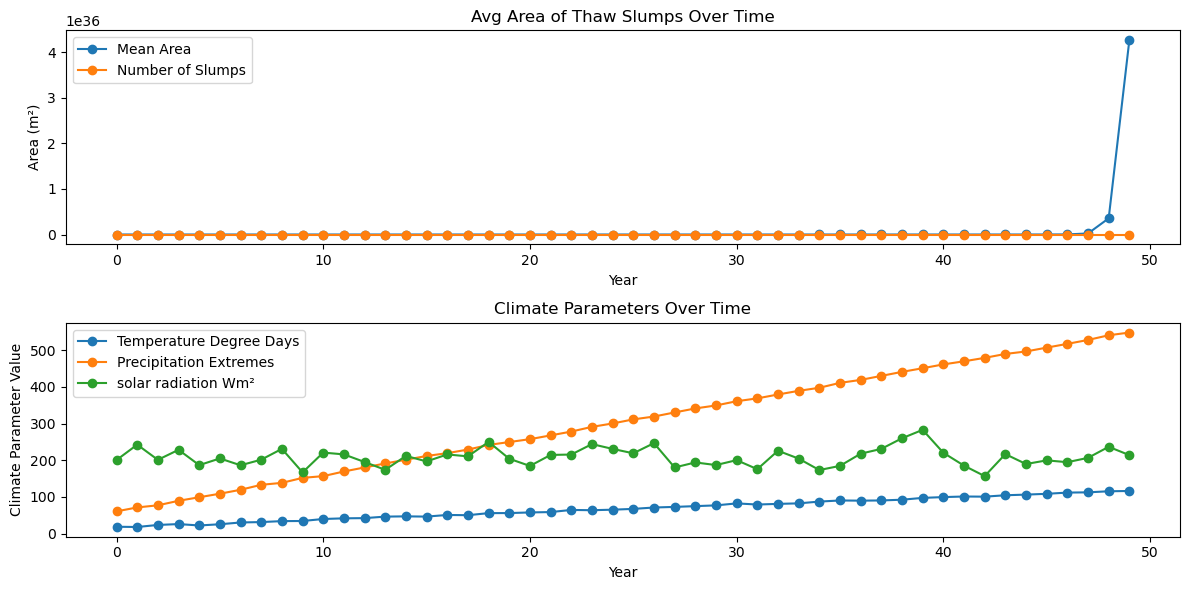

In [1]:
# first we need some data. Here we generate a time series of thaw slums and climate parameters. New slumps for example
# are initiated by rainfall, and existing slumps can fail due to hot summers. While in traditional state space model we look at newborns that change in survive and change in size,
# here we look at the area of thaw slumps, new ones are initiated and then persist. 

# This is a synthetic example, but it can be used to illustrate the concepts of Bayesian state space models.


import numpy as np
import pandas as pd

def simulate_thaw_slump_data(
    n_init           = 40,
    n_years          = 50,

    # --------- climate means and linear trends -------------------
    temp_start       = 18,      # °C·day in year 0
    temp_trend       = 2,       # °C·day added each year
    prec_start       = 60,      # mm  in year 0
    prec_trend       = 10,      # mm  added each year

    # --------- survival parameters  ------------------------------
    base_surv_prob   = 0.97,    # annual survival at Temp = 0
    surv_temp_slope  = -0.001,  # **per °C·day** change in log-odds

    # --------- growth parameters ---------------------------------
    base_growth      = 0.10,    # baseline proportional growth
    growth_prec_slope= 0.0045,  # **per mm** extra growth in log units

    # --------- initiation parameters -----------------------------
    init_base_lambda = 2.5,     # births yr⁻¹ at Temp = 0
    init_temp_slope  = 0.10,    # **extra births per °C·day**

    # --------- misc ----------------------------------------------
    sigma_growth     = 0.20,    # log-normal σ for growth noise
    seed             = 42
):
    rng  = np.random.default_rng(seed)

    # --------- 1. Generate climate time series -------------------
    years = np.arange(n_years)
    clim  = pd.DataFrame({
        "year"    : years,
        "temp_dd" : temp_start + temp_trend * years + rng.normal(0, 2, n_years),
        "prec_ext": prec_start + prec_trend * years + rng.normal(0, 2, n_years),
        "rad"     : rng.normal(210, 25, n_years)          # unused but kept
    })

    # --------- 2. Initialise population --------------------------
    rec, alive_ids, next_id = [], [], 0
    init_sizes = rng.lognormal(mean=2.4, sigma=0.35, size=n_init)

    for area0 in init_sizes:
        rec.append(dict(id=next_id, area=area0, alive=1,
                        new_init=1, **clim.loc[0]))
        alive_ids.append(next_id)
        next_id += 1

    # --------- 3. Annual loop ------------------------------------
    logit_base = np.log(base_surv_prob / (1 - base_surv_prob))

    for t in range(1, n_years):
        row = clim.loc[t]
        survivors = []

        # ---- SURVIVAL & GROWTH -----------------------------------
        for ind in alive_ids:
            last = next(r for r in rec if r["id"] == ind and r["year"] == t-1)

            logit_surv = logit_base + surv_temp_slope * row["temp_dd"]
            p_surv     = 1 / (1 + np.exp(-logit_surv))

            if rng.random() < p_surv:        # survives
                g_mean  = base_growth + growth_prec_slope * row["prec_ext"]
                growth  = rng.lognormal(mean=g_mean, sigma=sigma_growth)
                rec.append(dict(id=ind,
                                area=last["area"] * (1 + growth),
                                alive=1, new_init=0, **row))
                survivors.append(ind)
            else:                            # dies
                rec.append(dict(id=ind, area=np.nan,
                                alive=0, new_init=0, **row))

        # ---- INITIATIONS -----------------------------------------
        lam   = init_base_lambda + init_temp_slope * row["temp_dd"]
        lam   = max(lam, 0.1)                # keep λ positive
        n_new = rng.poisson(lam)

        for _ in range(n_new):
            rec.append(dict(id=next_id,
                            area=rng.lognormal(mean=2.2, sigma=0.30),
                            alive=1, new_init=1, **row))
            survivors.append(next_id)
            next_id += 1

        alive_ids = survivors

    return pd.DataFrame(rec), clim




df, clim = simulate_thaw_slump_data()
print(df.head())

# visualize the popluation and area as well as climate parameters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.groupby("year")["area"].mean(), marker='o', label='Mean Area')
#plt.plot(df.groupby("year")["area"].sum(), marker='o', label='Total Area')
plt.plot(df.groupby("year")["alive"].sum(), marker='o', label='Number of Slumps')
plt.title('Avg Area of Thaw Slumps Over Time')
plt.xlabel('Year')
plt.ylabel('Area (m²)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(clim['year'], clim['temp_dd'], label='Temperature Degree Days', marker='o')
plt.plot(clim['year'], clim['prec_ext'], label='Precipitation Extremes', marker='o')
plt.plot(clim['year'], clim['rad'], label='solar radiation Wm²', marker='o')
plt.title('Climate Parameters Over Time')
plt.xlabel('Year')
plt.ylabel('Climate Parameter Value')
plt.legend()
plt.tight_layout()
plt.show()




In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import arviz as az, pymc as pm
from scipy import stats as st
from IPython.display import display

In [3]:
# -------------------------------------------------------------------
# 1. Dimensions: how many years and how many individual slump IDs?
# -------------------------------------------------------------------
T   = clim.shape[0]          # Total number of calendar years in the
                             # climate table.  Acts as the time axis.
ids = df["id"].unique()      # Unique identifiers for every thaw slump
I   = len(ids)               # Total number of individuals (rows).

# -------------------------------------------------------------------
# 2. Pre-allocate core data matrices (shape: I × T)
#    Each matrix holds one variable for every (slump, year) cell.
#    • area_mat     – raw surface area (m²); NaN means “not observed”.
#    • log_area_mat – ln(1 + area); stabilises variance for modelling.
#    • alive_mat    – binary 0/1 indicator (1 = alive, 0 = dead/absent).
# -------------------------------------------------------------------
area_mat     = np.full((I, T), np.nan)
log_area_mat = np.full((I, T), np.nan)
alive_mat    = np.zeros((I, T), dtype=int)

# -------------------------------------------------------------------
# 3. Helper dictionary: external slump IDs → row index (0 … I−1)
#    Makes look-ups O(1) when we loop through the DataFrame.
# -------------------------------------------------------------------
id2idx = {slump_id: row for row, slump_id in enumerate(ids)}

# -------------------------------------------------------------------
# 4. Populate the matrices with the long-format records in df.
#    Each row ‘r’ has columns id, year, area, alive…
# -------------------------------------------------------------------
for _, r in df.iterrows():
    i = id2idx[r.id]         # Matrix row for this slump
    t = int(r.year)          # Matrix column (year index, 0-based)

    area_mat[i, t]     = r.area                     # raw area
    log_area_mat[i, t] = np.log1p(r.area)           # ln(1 + area)
    alive_mat[i, t]    = r.alive                    # 0/1 alive flag

# -------------------------------------------------------------------
# 5. Build a climate design matrix (T × 3) and z-score it.
#    Standardising to mean 0, SD 1 puts all covariates on the same
#    scale, so regression coefficients are comparable and priors
#    (e.g. N(0, 1)) become “weakly informative” in a consistent way.
# -------------------------------------------------------------------
clim_raw = clim[["temp_dd", "prec_ext", "rad"]].values    # extract cols
clim_mat = (clim_raw - clim_raw.mean(axis=0)) / clim_raw.std(axis=0)


In [4]:
# ------------------------------------------------------------------
# Helper function: slice the big I × T matrices into the *row-wise*
# design matrices that the PyMC model expects.
#
# • For SURVIVAL we need, per observation:
#      – current log-area          (covariate)
#      – current-year climate      (covariate)
#      – alive / dead next year    (binary target)
#      – individual index          (for random intercepts)
#
# • For GROWTH we need the subset that *survived* next year:
#      – log-area at year t        (covariate)
#      – current-year climate      (covariate)
#      – log-area at year t+1      (continuous target)
#
# The function returns seven NumPy arrays in that order.
# ------------------------------------------------------------------
def build_surv_grow():

    # Lists will be appended in the loop and later cast to arrays
    surv_size, surv_clim, surv_out, surv_idx = [], [], [], []
    grow_prev, grow_clim, grow_next          = [], [], []

    # Loop over all but the final year (because we look ahead to t+1)
    for t in range(T - 1):
        for i in range(I):
            if alive_mat[i, t]:                    # slump i is alive in year t …

                # ---------- SURVIVAL row  ----------
                surv_size.append(log_area_mat[i, t])
                surv_clim.append(clim_mat[t])      # 3-element climate vector
                surv_out.append(alive_mat[i, t+1]) # 0/1 next-year status
                surv_idx.append(i)                 # individual id (row index)

                # ---------- GROWTH row (only if still alive next year) ----------
                if alive_mat[i, t+1]:
                    grow_prev.append(log_area_mat[i, t])   # size at t
                    grow_clim.append(clim_mat[t])          # same climate row
                    grow_next.append(log_area_mat[i, t+1]) # size at t+1

    # Convert all seven Python lists to NumPy arrays and return
    return map(np.asarray, (
        surv_size, surv_clim, surv_out, surv_idx,
        grow_prev, grow_clim, grow_next
    ))

# Unpack the generator into named arrays
(surv_size, surv_clim, surv_out, surv_idx,
 grow_prev, grow_clim, grow_next) = build_surv_grow()


# ------------------------------------------------------------------
# BIRTH (new-initiation) data
# ------------------------------------------------------------------

# N_t: total number of *alive* slumps each calendar year
N_t = alive_mat.sum(axis=0)                      # shape (T,)

# birth_cnts: count of brand-new slumps per year.
#   • Filter df for rows flagged new_init==1
#   • Group by calendar year, count rows
#   • Reindex so we have an entry for *every* year (fill missing with 0)
birth_cnts = (
    df[df.new_init == 1]
      .groupby("year").size()
      .reindex(range(T), fill_value=0)
      .values                                         # shape (T,)
)

# birth_clim: climate covariates aligned to *birth outcome* years,
# i.e. predictor at year t influences births observed in year t
# (the first row corresponds to year 1 because births_t predicts counts_t)
birth_clim = clim_mat[1:]                             # shape (T-1, 3)

# N_prev: previous-year population size, z-scored
N_prev = (N_t[:-1] - N_t[:-1].mean()) / N_t[:-1].std()

# ice_offset:
#   An offset term to express births per 100 m² of ground-ice area.
#   In log-link space an offset is just +log(exposure).
ice_area   = 100                                     # exposure in m²
ice_offset = np.log(ice_area) * np.ones_like(birth_cnts[1:])  # shape (T-1,)


In [ ]:
# -------------------------------------------------------------------
#  BAYESIAN STATE-SPACE MODEL
# -------------------------------------------------------------------
with pm.Model() as pop_model:

    # ========= DATA HOLDERS (observed, not stochastic) ==========
    S_size   = pm.MutableData("S_area",  surv_size)   # log-area of each alive slump in year t
    S_clim   = pm.MutableData("S_clim",  surv_clim)   # 3-element climate vector for that year
    S_out    = pm.MutableData("S_out",   surv_out)    # 0/1: survived to t+1?
    S_idx    = pm.MutableData("S_idx",   surv_idx)    # row index → random intercept

    G_prev   = pm.MutableData("G_prev",  grow_prev)   # log-area at t   (growth covariate)
    G_clim   = pm.MutableData("G_clim",  grow_clim)   # climate at t    (growth covariate)
    G_next   = pm.MutableData("G_next",  grow_next)   # log-area at t+1 (growth target)

    B_cnt    = pm.MutableData("B_cnt",   birth_cnts[1:]) # observed # new slumps in year t
    B_clim   = pm.MutableData("B_clim",  birth_clim)     # climate at t (initiation covariate)
    N_prev_d = pm.MutableData("N_prev",  N_prev)         # z-scored pop size at t–1
    B_off    = pm.MutableData("B_off",   ice_offset)     # log(ice area) exposure offset

    # ------------------------------------------------------------
    #  SURVIVAL  —  Does a slump live to next year?
    # ------------------------------------------------------------
    alpha_surv_pop = pm.Normal(           # Normal(0,1.5)
        "alpha_surv_pop", 0, 1.5)         #  Population-level log-odds of survival

    sigma_surv = pm.HalfNormal(           # HalfNormal(0.5)
        "sigma_surv", 0.5)                #  SD of between-slump survival baselines

    alpha_surv_offset = pm.Normal(        # Normal(0,1)
        "alpha_surv_offset", 0, 1, shape=I)  #  Raw random effect for each slump i

    alpha_surv_i = pm.Deterministic(      # Derived node
        "alpha_surv_i",                   #  Actual intercept for slump i
        alpha_surv_pop + alpha_surv_offset * sigma_surv)

    beta_size = pm.Normal(                # Normal(0,1)
        "beta_size", 0, 1)                #  Effect of current log-area on survival odds

    # --- Spike-and-slab for 3 climate slopes -------------------
    pi_surv = pm.Beta(                    # Beta(1,1)
        "pi_surv", 1, 1, shape=3)         #  Prior inclusion prob for each climate driver
    z_surv  = pm.Bernoulli(               # Bernoulli(pi_surv)
        "z_surv", p=pi_surv, shape=3)     #  0/1 mask: include climate j?
    beta_raw = pm.Normal(                 # Normal(0,0.3)
        "beta_raw", 0, 0.3, shape=3)      #  Raw slope if included
    beta_clim = pm.Deterministic(         # Derived
        "beta_clim", z_surv * beta_raw)   #  Active climate slopes (masked)

    logit_p = (alpha_surv_i[S_idx] +
               beta_size * S_size +
               pm.math.sum(S_clim * beta_clim, axis=1))

    pm.Bernoulli("persistence",           # Bernoulli
                 logit_p=logit_p,         #  Predicted survival probability
                 observed=S_out)

    # ------------------------------------------------------------
    #  GROWTH  —  Log-area change between t and t+1
    # ------------------------------------------------------------
    alpha_grow = pm.Normal(               # Normal(0,1)
        "alpha_grow", 0, 1)               #  Mean log-growth at mean climate & size 0

    rho = pm.TruncatedNormal(             # TruncNormal(μ=1,σ=0.5)
        "rho", 1, 0.5, lower=0, upper=2)  #  AR(1) carry-over of size

    pi_grow  = pm.Beta("pi_grow", 1, 1, shape=3)       # Inclusion probs (growth)
    z_grow   = pm.Bernoulli("z_grow", p=pi_grow, shape=3)
    gamma_raw = pm.Normal("gamma_raw", 0, 0.3, shape=3)
    gamma_clim = pm.Deterministic("gamma_clim", z_grow * gamma_raw)  # Climate slopes

    sigma_grow = pm.HalfNormal("sigma_grow", 0.5)      # SD of growth residuals
    nu_grow    = pm.Exponential("nu_grow", 1/15) + 2   # Student-t df (>2)

    mu_grow = (alpha_grow +
               rho * G_prev +
               pm.math.sum(G_clim * gamma_clim, axis=1))

    pm.StudentT("expansion",                           # Student-t
                mu=mu_grow, sigma=sigma_grow, nu=nu_grow,
                observed=G_next)                       #  Next-year log-area

    # ------------------------------------------------------------
    #  INITIATIONS  —  How many new slumps form this year?
    # ------------------------------------------------------------
    alpha_init = pm.Normal("alpha_init", 0, 1)         # Log-rate at mean climate & N_prev
    phi        = pm.Normal("phi", 0, 1)                # Density feedback on log-rate

    pi_init  = pm.Beta("pi_init", 1, 1, shape=3)       # Inclusion probs (initiation)
    z_init   = pm.Bernoulli("z_init", p=pi_init, shape=3)
    delta_raw = pm.Normal("delta_raw", 0, 0.3, shape=3)
    delta_clim= pm.Deterministic("delta_clim", z_init * delta_raw)  # Climate slopes

    log_lambda = (alpha_init +
                  phi * N_prev_d +
                  pm.math.sum(B_clim * delta_clim, axis=1) +
                  B_off)                               # ln λ for Poisson births

    lambda_safe = pm.math.exp(log_lambda)              # Poisson mean (≥0)

    psi = pm.Beta("psi", 2, 2)                         # Structural-zero probability

    pm.ZeroInflatedPoisson("new_slumps",               # ZIP
                           psi=psi,                    #  Bernoulli zero layer
                           mu=lambda_safe,             #  Poisson λ
                           observed=B_cnt)

    # ------------------------------------------------------------
    #  SAMPLER  —  NUTS for continuous RVs, Metropolis for z_*
    # ------------------------------------------------------------
    trace = pm.sample(draws=4000, tune=3000,
                      chains=4, target_accept=0.99,
                      random_seed=2025, progressbar=True)


c:\Users\castad001\AppData\Local\miniconda3\miniconda\envs\plotting\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [alpha_surv_pop, sigma_surv, alpha_surv_offset, beta_size, pi_surv, beta_raw, alpha_grow, rho, pi_grow, gamma_raw, sigma_grow, nu_grow, alpha_init, phi, pi_init, delta_raw, psi]
>BinaryGibbsMetropolis: [z_surv, z_grow, z_init]


Output()

In [14]:
# next we will evaluate the model fit using posterior predictive checks
# The posterior predictive checks will help us assess how well the model predicts the observed data.

# posterior-predictive draws of the 'expansion' node 
# (the continuous outcome of the growth process)
with pop_model:
    ppc_growth = pm.sample_posterior_predictive(
        trace,
        var_names=["expansion"],         # just the continuous outcome
        progressbar=True,
        return_inferencedata=False,
    )

    #az.plot_pair(trace, var_names=["sigma_surv", "alpha_surv_pop"], divergences=True,kind="kde")



y_obs  = grow_next                       # observed log-areas at t+1
y_pred = ppc_growth["expansion"]         # shape (draw, obs)

# 1) Residual SD 
y_pred_mean = y_pred.mean(axis=0)
residuals   = y_obs - y_pred_mean
resid_sd    = residuals.std(ddof=1)

# 2) Prediction SD 
pred_sd = y_pred.std(ddof=1)             # SD across draws *and* obs

# 3) Bayesian R²  (Gelman et al. 2019) 
r2 = 1 - (residuals.var(ddof=1) / y_obs.var(ddof=1))

# 4) Posterior-predictive log score (replaces Harvey GF for heavy tails) ----
log_score = np.mean(st.t.logpdf(residuals,
                                df=float(trace.posterior["nu_grow"].mean()),
                                loc=0,
                                scale=float(trace.posterior["sigma_grow"].mean())))

# -------- assemble a neat one-row DataFrame like the blog’s table ----------
model_summary = pd.DataFrame(
    [[resid_sd, pred_sd, r2, log_score]],
    columns=["Residual SD", "Prediction SD", "R²", "Posterior predictive log-score"]
).round(3)

# from this we get the residual SD, prediction SD, Bayesian R², and posterior predictive log-score. 
# The residual SD indicates how well the model captures the variability in the growth of thaw slumps (better is lower), 
# while the prediction SD shows the uncertainty in the predictions (better is lower). 
# The Bayesian R² provides a measure of how much variance in the data is explained by the model (better is higher), 
# and the posterior predictive log-score gives an indication of the model's predictive performance (better is higher).
display(model_summary)

Sampling: [expansion]


Output()

,Residual SD,Prediction SD,R²,Posterior predictive log-score
0,0.138,7.67,1.0,0.551


In [15]:
# Now we can summarize the posterior draws of the model parameters, including the inclusion statistics for the climate variables.
# The inclusion statistics will help us understand the importance of each climate variable in the model.
# we also compute the posterior inclusion probabilities and Bayes factors for the climate variables.
# The Bayes factors indicate how much more likely the data is under the model with the climate variable included compared to the model without it.


def inclusion_stats(z, pi=0.5):
    """Posterior inclusion probability & BF from spike-and-slab indicator."""
    post = z.mean()
    bf   = (post / (1 - post)) / (pi / (1 - pi))
    return pi, post, bf


rows, zmap = [], {
    "beta_clim":  "z_surv",
    "gamma_clim": "z_grow",
    "delta_clim": "z_init"
}


for par in ["alpha_surv_pop", "beta_size"]:
    draws = trace.posterior[par].values.ravel()
    try:                                         # try ArviZ first
        bf = float(az.bayes_factor(draws, point=0)["BF"])
    except Exception:
        bf = np.inf
    rows.append([par, 1, 1, bf,
                 draws.mean(), draws.std(), *az.hdi(draws, 0.95)])


for coef, zname in zmap.items():
    coeff  = trace.posterior[coef].values       # (chain, draw, 3)
    z_draw = trace.posterior[zname].values
    for j in range(coeff.shape[2]):
        d = coeff[..., j].ravel()
        prior, post, bf_sd = inclusion_stats(z_draw[..., j].ravel())
        try:
            bf_az = float(az.bayes_factor(d, point=0)["BF"])
            bf = bf_az if np.isfinite(bf_az) else bf_sd
        except Exception:
            bf = bf_sd
        rows.append([f"{coef}[{j}]", prior, post, bf,
                     d.mean(), d.std(), *az.hdi(d, 0.95)])


for par in ["alpha_grow", "rho", "alpha_init", "phi",
            "sigma_grow", "psi", "nu_grow", "sigma_surv"]:
    d = trace.posterior[par].values.ravel()
    try:
        bf = float(az.bayes_factor(d, point=0)["BF"])
    except Exception:
        bf = np.inf
    rows.append([par, 1, 1, bf,
                 d.mean(), d.std(), *az.hdi(d, 0.95)])

posterior_tbl = (
    pd.DataFrame(rows, columns=[
        "Coefficient", "P(incl)", "P(incl|data)", "BF_incl",
        "Mean", "SD", "HDI-5%", "HDI-95%"
    ])
    .round(3)
    .set_index("Coefficient")
)






### Posterior summary (natural units)

,Explanation,P(incl),P(incl|data),BF_incl,Mean,SD,HDI-5%,HDI-95%
Coefficient,,,,,,,,
alpha_surv_pop,Population intercept (survival log-odds),1.0,1.000,inf,34.709,0.223,22.309,53.571
beta_size,Size slope on survival (log-area),1.0,1.000,inf,0.988,0.018,0.951,1.022
beta_clim[0],Temp DD slope on survival,0.5,0.381,0.616,1.001,0.109,0.995,1.012
beta_clim[1],Extreme precip slope on survival,0.5,0.402,0.672,1.000,0.113,0.999,1.002
beta_clim[2],Radiation slope on survival,0.5,0.797,3.928,1.007,0.119,1.000,1.015
gamma_clim[0],Temp DD slope on growth,0.5,0.432,0.762,0.141,0.056,0.000,0.512
gamma_clim[1],Extreme precip slope on growth,0.5,0.998,591.593,0.138,0.056,0.065,0.172
gamma_clim[2],Radiation slope on growth,0.5,0.012,0.012,0.000,0.000,0.000,0.000
delta_clim[0],Temp DD slope on initiation,0.5,0.990,102.226,1.027,0.255,1.010,1.045


### Model evaluation (growth component)

,Residual SD,Prediction SD,R²,Posterior predictive log-score
0,0.138,7.67,1.0,0.551


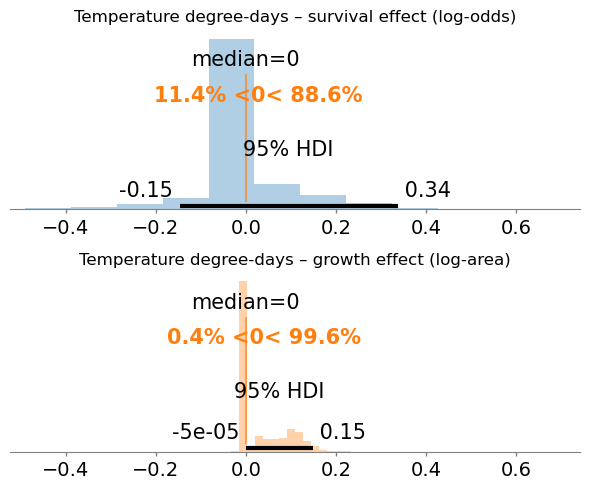

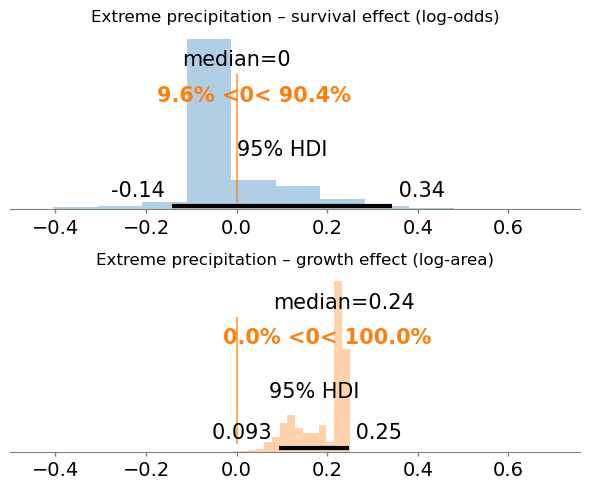

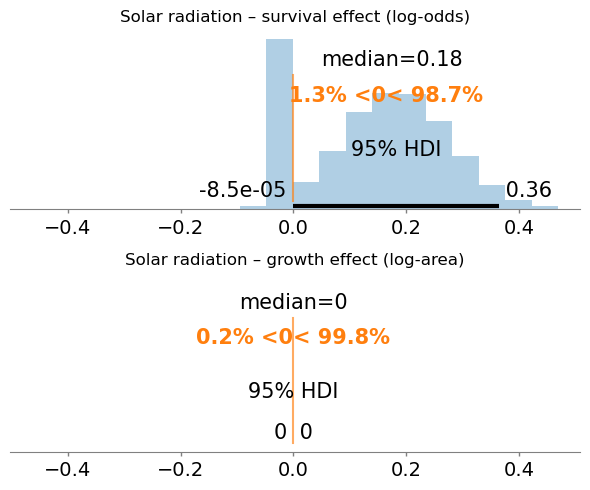

### Plain-language summaries

* **Temperature degree-days** — +1 SD multiplies survival odds by ≈ 1.00× (95 % CI 0.86–1.40) and changes next-year area by ≈ 0.0% (95 % CI -0.0%–16.0%).

* **Extreme precipitation** — +1 SD multiplies survival odds by ≈ 1.00× (95 % CI 0.87–1.41) and changes next-year area by ≈ 26.8% (95 % CI 9.7%–28.1%).

* **Solar radiation** — +1 SD multiplies survival odds by ≈ 1.19× (95 % CI 1.00–1.44) and changes next-year area by ≈ 0.0% (95 % CI 0.0%–0.0%).

In [28]:
# ---------------------------------------------------------------
# 1.  Build the look-up table: parameter → plain-English label
# ---------------------------------------------------------------
param_expl = [
    ("alpha_surv_pop", "Population intercept (survival log-odds)"),
    ("beta_size",      "Size slope on survival (log-area)"),
    ("beta_clim[0]",   "Temp DD slope on survival"),
    ("beta_clim[1]",   "Extreme precip slope on survival"),
    ("beta_clim[2]",   "Radiation slope on survival"),
    ("alpha_grow",     "Intercept: baseline growth (log-area)"),
    ("rho",            "Autoregressive size effect"),
    ("gamma_clim[0]",  "Temp DD slope on growth"),
    ("gamma_clim[1]",  "Extreme precip slope on growth"),
    ("gamma_clim[2]",  "Radiation slope on growth"),
    ("sigma_grow",     "Residual SD (growth)"),
    ("alpha_init",     "Intercept: baseline initiation"),
    ("phi",            "Density feedback on initiations"),
    ("delta_clim[0]",  "Temp DD slope on initiation"),
    ("delta_clim[1]",  "Extreme precip slope on initiation"),
    ("delta_clim[2]",  "Radiation slope on initiation"),
    ("psi",            "Zero-inflation probability"),
    ("nu_grow",        "Student-t degrees-of-freedom"),
    ("sigma_surv",     "SD of random survival intercepts")
]
param_tbl = (pd.DataFrame(param_expl, columns=["Parameter", "Explanation"])
             .set_index("Parameter"))

# ---------------------------------------------------------------
# 2.  Join with the numeric posterior summary you already built
#     (posterior_tbl must exist at this point)
# ---------------------------------------------------------------
combined_tbl = (
    posterior_tbl
    .join(param_tbl)               # match on parameter name (index)
    .reindex(columns=[             # tidy column order
        "Explanation",
        "P(incl)", "P(incl|data)", "BF_incl",
        "Mean", "SD", "HDI-5%", "HDI-95%"
    ])
)

# ---------------------------------------------------------------
#  back-transform to natural units
# ---------------------------------------------------------------
import numpy as np

# SD of each climate column (needed to undo z-scaling)
clim_sd = dict(zip(
    ["temp_dd", "prec_ext", "rad"],
    clim_raw.std(axis=0)
))

def odds_ratio(x):  return np.exp(x)
def pct_change(x):  return (np.exp(x) - 1) * 100
def rate_mult(x):   return np.exp(x)

for p in combined_tbl.index:
    mean, lo, hi = combined_tbl.loc[p, ["Mean", "HDI-5%", "HDI-95%"]]

    # --- SURVIVAL terms (log-odds → odds ratio) -----------------
    if p in ["alpha_surv_pop", "beta_size"] or p.startswith("beta_clim"):
        if p.startswith("beta_clim"):
            j = int(p.split("[")[1][0])
            sd = clim_sd[list(clim_sd.keys())[j]]
            mean, lo, hi = mean / sd, lo / sd, hi / sd
        mean, lo, hi = odds_ratio(mean), odds_ratio(lo), odds_ratio(hi)

    # --- GROWTH terms (log scale → % change) --------------------
    elif p in ["alpha_grow"] or p.startswith("gamma_clim"):
        if p.startswith("gamma_clim"):
            j = int(p.split("[")[1][0])
            sd = clim_sd[list(clim_sd.keys())[j]]
            mean, lo, hi = mean / sd, lo / sd, hi / sd
        mean, lo, hi = pct_change(mean), pct_change(lo), pct_change(hi)

    # --- INITIATION terms (log λ → rate multiplier) -------------
    elif p in ["alpha_init", "phi"] or p.startswith("delta_clim"):
        if p.startswith("delta_clim"):
            j = int(p.split("[")[1][0])
            sd = clim_sd[list(clim_sd.keys())[j]]
            mean, lo, hi = mean / sd, lo / sd, hi / sd
        mean, lo, hi = rate_mult(mean), rate_mult(lo), rate_mult(hi)

    combined_tbl.loc[p, ["Mean", "HDI-5%", "HDI-95%"]] = [mean, lo, hi]



# ---------------------------------------------------------------
# 3.  Display everything
# ---------------------------------------------------------------
from IPython.display import display, Markdown

display(Markdown("### Posterior summary (natural units)"))
display(combined_tbl.round(3))

display(Markdown("### Model evaluation (growth component)"))
display(model_summary)


# ---------------------------------------------------------------
# 4.  Climate-covariate effect plots and plain-language bullets
#     (unchanged from your original code)
# ---------------------------------------------------------------
cov_names = ["Temperature degree-days",
             "Extreme precipitation",
             "Solar radiation"]
interpretations = []

for j, cov in enumerate(cov_names):
    beta  = trace.posterior["beta_clim"].values[..., j].ravel()
    gamma = trace.posterior["gamma_clim"].values[..., j].ravel()

    fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
    az.plot_posterior(beta,  ax=ax[0], hdi_prob=0.95,
                      ref_val=0, color="C0", kind="hist",
                      point_estimate="median")
    ax[0].set_title(f"{cov} – survival effect (log-odds)")

    az.plot_posterior(gamma, ax=ax[1], hdi_prob=0.95,
                      ref_val=0, color="C1", kind="hist",
                      point_estimate="median")
    ax[1].set_title(f"{cov} – growth effect (log-area)")
    plt.tight_layout(); plt.show()

    odds_med = np.exp(np.median(beta))
    odds_low, odds_hi = np.exp(az.hdi(beta, 0.95))
    pct_med  = (np.exp(np.median(gamma)) - 1) * 100
    pct_low, pct_hi = (np.exp(az.hdi(gamma, 0.95)) - 1) * 100

    interpretations.append(
        f"* **{cov}** — +1 SD multiplies survival odds by "
        f"≈ {odds_med:.2f}× (95 % CI {odds_low:.2f}–{odds_hi:.2f}) "
        f"and changes next-year area by ≈ {pct_med:.1f}% "
        f"(95 % CI {pct_low:.1f}%–{pct_hi:.1f}%)."
    )

display(Markdown("### Plain-language summaries"))
for line in interpretations:
    display(Markdown(line))


C:\Users\castad001\AppData\Local\Temp\ipykernel_48284\2686340124.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]


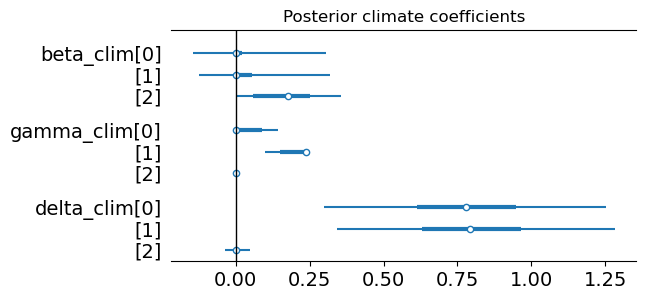

In [17]:
# We can also visualise the impacts of climate on the survival, growth, and initiation of thaw slumps. 
clim_labels = ["temperature degree-days", "precipitation extremes", "radiation"]
n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]

# We can  plot the posterior distributions of the climate coefficients to see how they impact the survival, growth, and initiation of thaw slumps.
az.plot_forest(
    trace,
    var_names=[r"beta_clim", r"gamma_clim", r"delta_clim"],
    combined=True,  # merge chains
    figsize=(6, 3),
)
plt.axvline(0, color="k", lw=1)
plt.title("Posterior climate coefficients"); plt.show()



C:\Users\castad001\AppData\Local\Temp\ipykernel_48284\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_48284\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_48284\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)


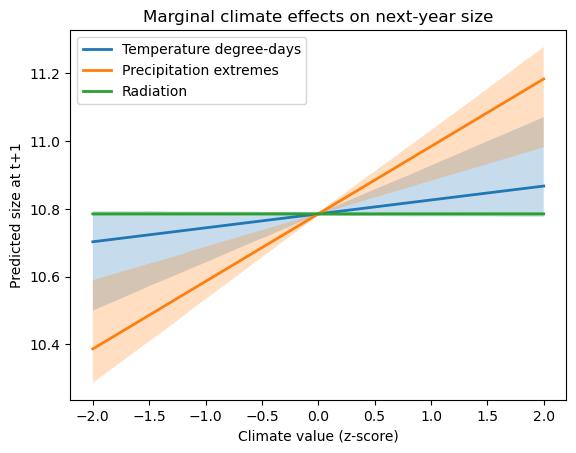

In [18]:
# Maybe we wamt to see the marginal effects of each climate variable on the next year's size of thaw slumps.
alpha  = trace.posterior["alpha_grow"].stack(samples=("chain", "draw")).values       # (n_draws,)
rho  = trace.posterior["rho"].stack(samples=("chain", "draw")).values           # (n_draws,)
gamma  = trace.posterior["gamma_clim"].stack(samples=("chain", "draw")).values      # (3, n_draws)

s0 = 10                                 # reference current size
grid = np.linspace(-2, 2, 100)          # ±2 SD for each climate var

for j, lab in enumerate(clim_labels):
    X = np.zeros((grid.size, 3))
    X[:, j] = grid                      # vary ONE covariate, others kept at 0
    mu = alpha[None, :] + rho[None, :] * s0 + (X @ gamma)      # (grid, draws)

    mu_mean = mu.mean(1)
    mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)

    plt.fill_between(grid, mu_hdi[:, 0], mu_hdi[:, 1], alpha=0.25)
    plt.plot(grid, mu_mean, lw=2, label=lab.capitalize())

plt.xlabel("Climate value (z-score)")
plt.ylabel("Predicted size at t+1")
plt.title("Marginal climate effects on next-year size")
plt.legend(); plt.show()





C:\Users\castad001\AppData\Local\Temp\ipykernel_48284\3975446578.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  init_hdi   = az.hdi(init_preds.T, 0.94)


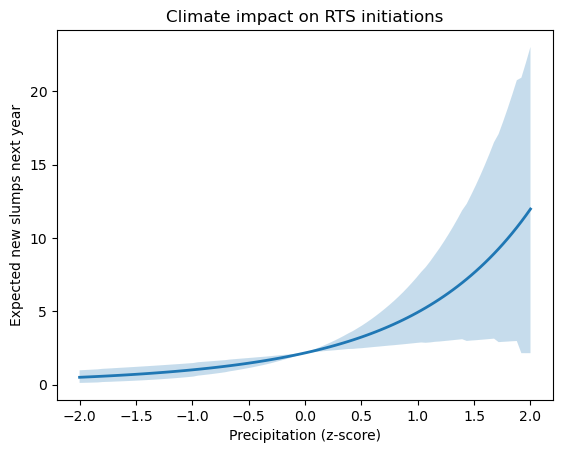

In [19]:
#The elasticities of the growth model can be visualised to see how sensitive the growth is to changes in climate variables.
alpha_i = trace.posterior["alpha_grow"].stack(samples=("chain","draw")).values
phi     = trace.posterior["phi"].stack(samples=("chain","draw")).values
delta   = trace.posterior["delta_clim"].stack(samples=("chain","draw")).values

N_mean  = N_prev.mean()
prec_grid = grid
init_preds = []

for prec in prec_grid:
    X = np.array([0, prec, 0])            # vary precipitation only
    loglam = alpha_i + phi * N_mean + (delta.T @ X)
    init_preds.append(np.exp(loglam))

init_preds = np.array(init_preds)
init_mean  = init_preds.mean(1)
init_hdi   = az.hdi(init_preds.T, 0.94)

plt.fill_between(prec_grid, init_hdi[:,0], init_hdi[:,1], alpha=.25)
plt.plot(prec_grid, init_mean, lw=2)
plt.xlabel("Precipitation (z-score)")
plt.ylabel("Expected new slumps next year")
plt.title("Climate impact on RTS initiations"); plt.show()

TRACE PLOTS → confirm chain mixing and stationarity.


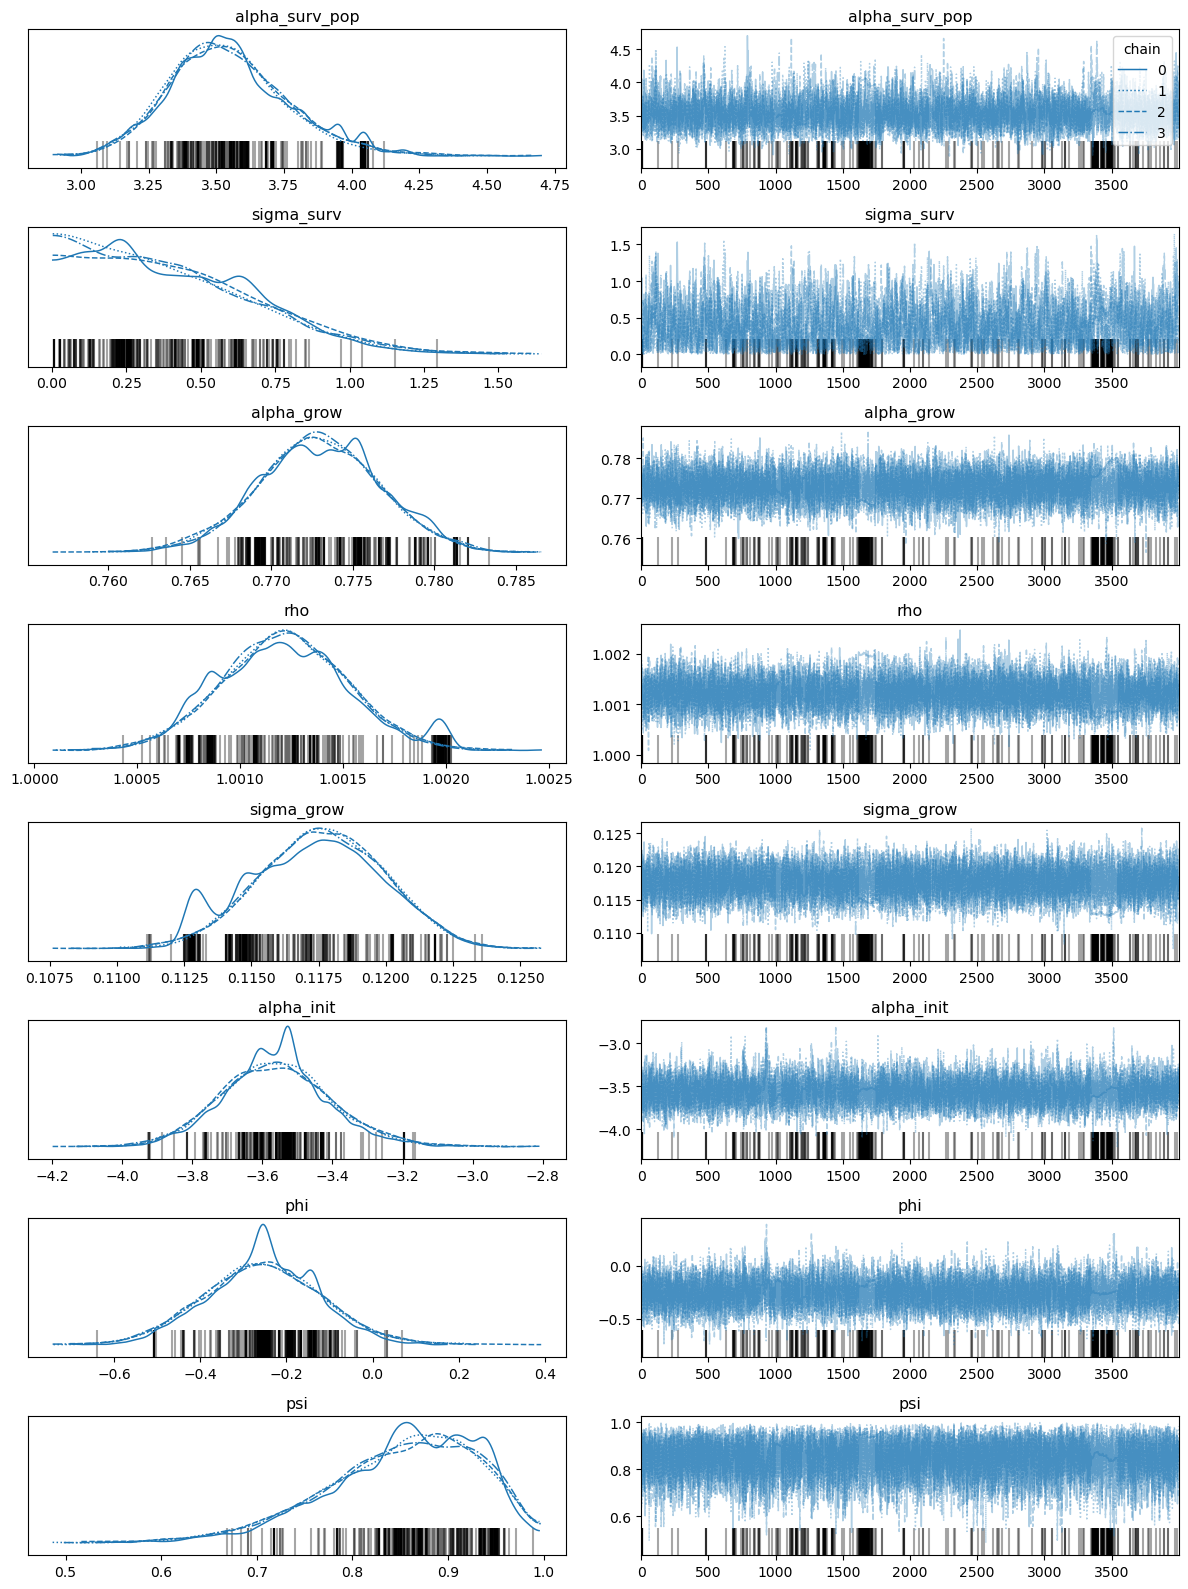

In [21]:
# ---------------------------------------------------------------
# Trace plots – visual diagnose mixing / stationarity
# ---------------------------------------------------------------
from IPython.display import display
import arviz as az
import matplotlib.pyplot as plt

print("TRACE PLOTS → confirm chain mixing and stationarity.")

# pick whichever variable names you care about
vars_to_check = [
    "alpha_surv_pop", "sigma_surv",
    "alpha_grow", "rho", "sigma_grow",
    "alpha_init", "phi", "psi"
]

az.plot_trace(trace, var_names=vars_to_check, legend=True)
plt.tight_layout()
plt.show()
